In [100]:
#Librerias necesarias
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import datetime
import random

import statsmodels.formula.api as smf
import statsmodels.api         as sm
import scipy

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [2]:
#Esta celda es para cargar los archivos de prueba

filesNames = ['2019_11_Q1','2019_11_Q2','2020_03_Q1',"2020_03_Q2",'2020_04_Q1','2020_04_Q2','2020_05_Q1']
pas=pd.read_csv('2019_11_Q1.csv',header=0,encoding='UTF-8')


In [3]:
#GENERAR COLUMNAS DE TRABAJO
def col_work(data):
    #Cambio del formato de las fechas
    data['FECHAREGISTRO'] = pd.to_datetime(data['FECHAREGISTRO'], format='%d/%m/%Y %H:%M:%S')
    #Columna que representa el dia de la semana. Sirve para diferenciar entre dia habil y fin de semana
    data["dia"]=data['FECHAREGISTRO'].dt.dayofweek

    #Función para asignar la franja del día
    def franja(i):
        pico_mañana_min = 5
        pico_mañana_max = 7
        pico_tarde_min = 14
        pico_tarde_max = 19

        if pico_mañana_min<i.hour<pico_mañana_max:
            return "1_peak"
        elif pico_tarde_min<i.hour<pico_tarde_max:
            return "2_peak"
        else:
            return "Off_peak"
    #Columna con la franja del dia
    data["franja"]=data['FECHAREGISTRO'].apply(franja)
col_work(pas)

In [4]:
#Función para calcular la carga en el data frame de entrada
def carga(df):
    df.sort_values(by=["SECUENCIARECORRIDO","FECHAREGISTRO"],inplace=True,ascending=True)
    df['FECHAREGISTRO_d'] = df['FECHAREGISTRO'].dt.day
    df['FECHAREGISTRO_m'] = df['FECHAREGISTRO'].dt.month
    df['delta_q'] = df['SUBENDELANTERA']+df['SUBENTRASERA']-df['BAJANDELANTERA']-df['BAJANTRASERA']
    df["carga"]=df.groupby(["SECUENCIARECORRIDO",'FECHAREGISTRO_d'])["delta_q"].cumsum()

In [5]:
carga(pas)

In [6]:
pas["carga_neg"]=0
pas["carga_neg"].where(pas["carga"]>0, 1,inplace=True) 

**Calculo del porcentaje de cargas negativas**

In [7]:
aggreg={"carga_neg":"sum","carga":"count"}
resu=pas.groupby("IDVEHICULO").agg(aggreg)
resu.reset_index(inplace=True)
resu.rename(columns={'carga':"total",'carga_neg':"total_neg"},inplace=True)
resu["p_neg"]=(resu["total_neg"]/resu["total"])*100
resu

,IDVEHICULO,total_neg,total,p_neg
0,1,818,3259,25.099724
1,2,130,2340,5.555556
2,3,4896,6777,72.244356
3,29,932,2284,40.805604
4,31,73,1799,4.057810
...,...,...,...,...
2100,6899,577,3495,16.509299
2101,6902,57,766,7.441253
2102,6903,330,1592,20.728643
2103,6906,65,739,8.795670


In [8]:
vehiculos = pd.read_csv('vehiculos.csv',header=0,engine='python')
data=resu.merge(vehiculos, on='IDVEHICULO', how='left')

In [9]:
data

,IDVEHICULO,total_neg,total,p_neg,PLACAVEHICULO,MODELO,CAPPASAJEROS,CAPPASAJEROSPIE,CAPPASAJEROSSENTADOS,IDEMPRESA,NOMBRES,IDENTIDADOPERA
0,1,818,3259,25.099724,EQN946,2017.0,23.0,5.0,18.0,2.0,HATOVIEJO,1.0
1,2,130,2340,5.555556,EQO059,2017.0,23.0,5.0,18.0,2.0,HATOVIEJO,1.0
2,3,4896,6777,72.244356,EQO060,2017.0,23.0,5.0,18.0,2.0,HATOVIEJO,1.0
3,29,932,2284,40.805604,TRE402,2006.0,32.0,13.0,19.0,2.0,HATOVIEJO,1.0
4,31,73,1799,4.057810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2100,6899,577,3495,16.509299,STB801,2014.0,19.0,0.0,19.0,42.0,SOTRAMES,1.0
2101,6902,57,766,7.441253,GDW799,2020.0,19.0,0.0,19.0,42.0,SOTRAMES,1.0
2102,6903,330,1592,20.728643,STB872,2014.0,19.0,0.0,19.0,42.0,SOTRAMES,1.0
2103,6906,65,739,8.795670,GDW941,2020.0,52.0,21.0,31.0,42.0,SOTRAMES,1.0


In [10]:
tec = pd.read_csv('tec.csv',header=0,engine='python')
tec.columns

Index(['EMPRESA', 'PROVEEDOR_TEC', 'Sistema'], dtype='object')

In [11]:
tec["PROVEEDOR_TEC"].unique()

array(['Sonar AVL', 'Distracker', 'Skytracking', 'OPTOCONTROL', 'BEA',
       'Stratos Group', 'Surinter', 'Stratos Group - Distracker', 'SONAR',
       'GTP', 'SURINTER', 'SONAR - BEA - STRATOS GROUP', 'STRATOS GROUP',
       'LOGIRASTREO', 'STRATOS GROUP - SONAR', 'SONAR - TM SOLUTIONS',
       'NEBULA ENGINEERING'], dtype=object)

In [12]:
ree2={'Sonar AVL':'Sonar_AVL', 
      'Stratos Group':'Stratos_Group',
      'Stratos Group - Distracker':'Stratos_Group_Distracker', 
      'SONAR - BEA - STRATOS GROUP':'SONAR_BEA_STRATOS GROUP', 
      'STRATOS GROUP':'Stratos_Group', 
      'STRATOS GROUP - SONAR':'STRATOS_GROUP_SONAR', 
      'SONAR - TM SOLUTIONS':'SONAR_TM_SOLUTIONS',
      'NEBULA ENGINEERING': 'NEBULA_ENGINEERING',
      'Surinter':'SURINTER'}
tec["PROVEEDOR_TEC"].replace(ree2,inplace=True)
tec["PROVEEDOR_TEC"].unique()

array(['Sonar_AVL', 'Distracker', 'Skytracking', 'OPTOCONTROL', 'BEA',
       'Stratos_Group', 'SURINTER', 'Stratos_Group_Distracker', 'SONAR',
       'GTP', 'SONAR_BEA_STRATOS GROUP', 'LOGIRASTREO',
       'STRATOS_GROUP_SONAR', 'SONAR_TM_SOLUTIONS', 'NEBULA_ENGINEERING'],
      dtype=object)

In [13]:
data.rename(columns={'NOMBRES':"EMPRESA"},inplace=True)
data=data.merge(tec, on='EMPRESA', how='left')
data.head()

,IDVEHICULO,total_neg,total,p_neg,PLACAVEHICULO,MODELO,CAPPASAJEROS,CAPPASAJEROSPIE,CAPPASAJEROSSENTADOS,IDEMPRESA,EMPRESA,IDENTIDADOPERA,PROVEEDOR_TEC,Sistema
0,1,818,3259,25.099724,EQN946,2017.0,23.0,5.0,18.0,2.0,HATOVIEJO,1.0,SURINTER,AMVA
1,2,130,2340,5.555556,EQO059,2017.0,23.0,5.0,18.0,2.0,HATOVIEJO,1.0,SURINTER,AMVA
2,3,4896,6777,72.244356,EQO060,2017.0,23.0,5.0,18.0,2.0,HATOVIEJO,1.0,SURINTER,AMVA
3,29,932,2284,40.805604,TRE402,2006.0,32.0,13.0,19.0,2.0,HATOVIEJO,1.0,SURINTER,AMVA
4,31,73,1799,4.057810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
ree={'AUTOMOVILES ITAGUI':'AUTO_ITAGUI', 
     'LA VALERIA':'LA_VALERIA',
     'EXPRESO GIRARDOTA':'EXP_GIRARDOTA', 
     'MOCAT�N': 'MOCATAN',
     'TRANSPORTES MEDELLIN CASTILLA':'TRANS_MED_CASTILLA', 
     'SOLO BUS':'SOLO_BUS', 
     'CONDUCCIONES PALENQUE ROBLEDAL':'COND_PALENQUE_ROBLEDAL'}
data["EMPRESA"].replace(ree,inplace=True)
data["EMPRESA"].unique()

array(['HATOVIEJO', nan, 'AUTO_ITAGUI', 'COOTRANS', 'SOTRAMES',
       'COOTRASENVI', 'TAXIGER', 'COOTRASANA', 'BELLANITA', 'LA_VALERIA',
       'COONATRA', 'SANTRA', 'EXP_GIRARDOTA', 'COOTRANSMON', 'RSM',
       'TEMSA', 'ARRIERITAS', 'TRANSMEBA', 'MOCATAN',
       'TRANS_MED_CASTILLA', 'SOLO_BUS', 'COMBUSES', 'COOMETROPOL',
       'COND_PALENQUE_ROBLEDAL', 'COOTRANSCOL'], dtype=object)

In [15]:
#vehiculos sin info
data["MODELO"].isnull().sum()/data["MODELO"].count()

0.013933547695605574

In [16]:
data.columns

Index(['IDVEHICULO', 'total_neg', 'total', 'p_neg', 'PLACAVEHICULO', 'MODELO',
       'CAPPASAJEROS', 'CAPPASAJEROSPIE', 'CAPPASAJEROSSENTADOS', 'IDEMPRESA',
       'EMPRESA', 'IDENTIDADOPERA', 'PROVEEDOR_TEC', 'Sistema'],
      dtype='object')

**MODELO LINEAL**

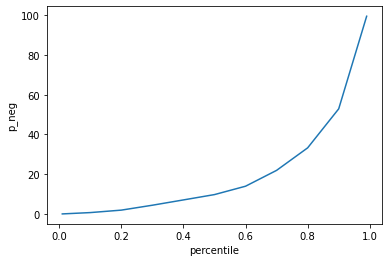

In [51]:
fig1=data["p_neg"].quantile([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]).plot()
fig1.set_xlabel("percentile")
fig1.set_ylabel("p_neg")
fig1.savefig("p_neq_percentil.jpg")

In [112]:
data[data["p_neg"]>data["p_neg"].quantile(0.8)][["IDVEHICULO","p_neg"]].to_csv("vehiculos_criticos.csv")

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

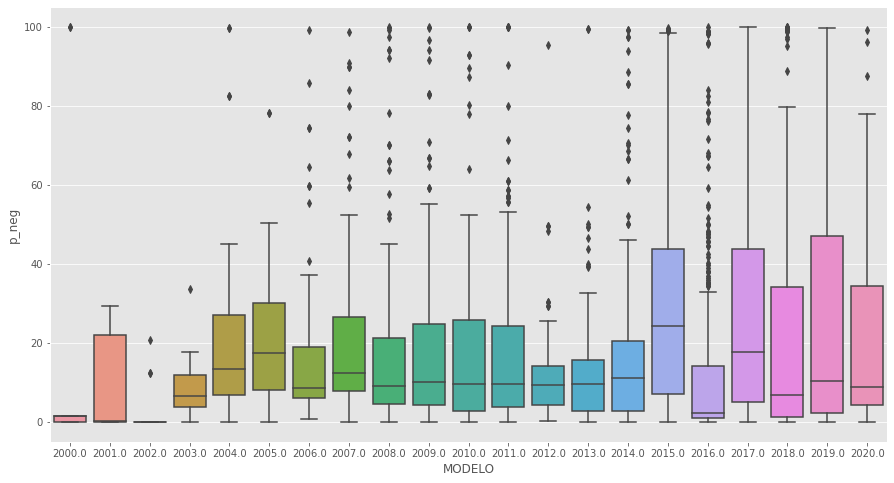

In [123]:
plt.figure(figsize=(15,8))
fig2=sns.boxplot(x="MODELO",y='p_neg',data=data)
fig2.savefig("boxplot_p_neg_modelo.jpg")

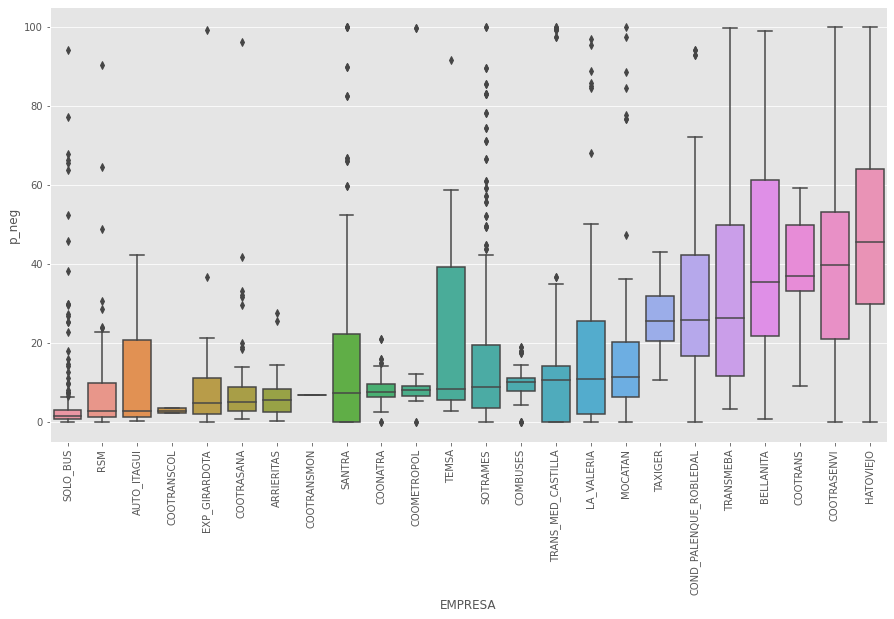

In [126]:
group=data.groupby("EMPRESA").agg({'p_neg':"median"}).sort_values(by="p_neg").reset_index()
order=list(group["EMPRESA"])
plt.figure(figsize=(15,8))
sns.boxplot(x="EMPRESA",y='p_neg',data=data,order=order)
plt.xticks(rotation= 90)
plt.savefig("boxplot_p_neg_empresa.png")

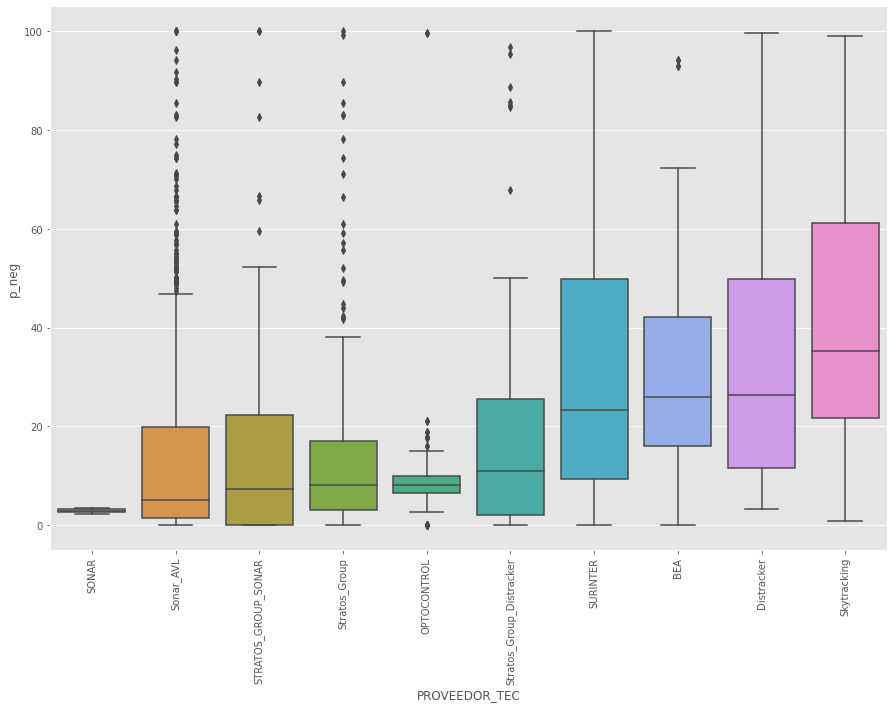

In [118]:
group2=data.groupby("PROVEEDOR_TEC").agg({'p_neg':"median"}).sort_values(by="p_neg").reset_index()
order2=list(group2["PROVEEDOR_TEC"])
plt.figure(figsize=(15,10))
sns.boxplot(x="PROVEEDOR_TEC",y='p_neg',data=data,order=order2)
plt.xticks(rotation= 90)
plt.savefig("boxplot_p_neg_provedor_tec.jpg")

In [38]:
#modelo lineal
data_d=pd.get_dummies(data,columns=["EMPRESA","PROVEEDOR_TEC"])
data_d.columns

Index(['IDVEHICULO', 'total_neg', 'total', 'p_neg', 'PLACAVEHICULO', 'MODELO',
       'CAPPASAJEROS', 'CAPPASAJEROSPIE', 'CAPPASAJEROSSENTADOS', 'IDEMPRESA',
       'IDENTIDADOPERA', 'Sistema', 'EMPRESA_ARRIERITAS',
       'EMPRESA_AUTO_ITAGUI', 'EMPRESA_BELLANITA', 'EMPRESA_COMBUSES',
       'EMPRESA_COND_PALENQUE_ROBLEDAL', 'EMPRESA_COOMETROPOL',
       'EMPRESA_COONATRA', 'EMPRESA_COOTRANS', 'EMPRESA_COOTRANSCOL',
       'EMPRESA_COOTRANSMON', 'EMPRESA_COOTRASANA', 'EMPRESA_COOTRASENVI',
       'EMPRESA_EXP_GIRARDOTA', 'EMPRESA_HATOVIEJO', 'EMPRESA_LA_VALERIA',
       'EMPRESA_MOCATAN', 'EMPRESA_RSM', 'EMPRESA_SANTRA', 'EMPRESA_SOLO_BUS',
       'EMPRESA_SOTRAMES', 'EMPRESA_TAXIGER', 'EMPRESA_TEMSA',
       'EMPRESA_TRANSMEBA', 'EMPRESA_TRANS_MED_CASTILLA', 'PROVEEDOR_TEC_BEA',
       'PROVEEDOR_TEC_Distracker', 'PROVEEDOR_TEC_OPTOCONTROL',
       'PROVEEDOR_TEC_SONAR', 'PROVEEDOR_TEC_STRATOS_GROUP_SONAR',
       'PROVEEDOR_TEC_SURINTER', 'PROVEEDOR_TEC_Skytracking',
       'PROVEED

**Coeficiente de correlación**

In [39]:
data_corr=data_d[["p_neg","MODELO","CAPPASAJEROS","total",'EMPRESA_ARRIERITAS',
                   'EMPRESA_AUTO_ITAGUI', 'EMPRESA_BELLANITA', 'EMPRESA_COMBUSES',
                   'EMPRESA_COND_PALENQUE_ROBLEDAL', 'EMPRESA_COOMETROPOL',
                   'EMPRESA_COONATRA', 'EMPRESA_COOTRANS', 'EMPRESA_COOTRANSCOL',
                   'EMPRESA_COOTRANSMON', 'EMPRESA_COOTRASANA', 'EMPRESA_COOTRASENVI',
                   'EMPRESA_EXP_GIRARDOTA', 'EMPRESA_HATOVIEJO', 'EMPRESA_LA_VALERIA',
                   'EMPRESA_MOCATAN', 'EMPRESA_RSM', 'EMPRESA_SANTRA', 'EMPRESA_SOLO_BUS',
                   'EMPRESA_SOTRAMES', 'EMPRESA_TAXIGER', 'EMPRESA_TEMSA',
                   'EMPRESA_TRANSMEBA', 'EMPRESA_TRANS_MED_CASTILLA', 'PROVEEDOR_TEC_BEA',
                   'PROVEEDOR_TEC_Distracker', 'PROVEEDOR_TEC_OPTOCONTROL',
                   'PROVEEDOR_TEC_SONAR', 'PROVEEDOR_TEC_STRATOS_GROUP_SONAR',
                   'PROVEEDOR_TEC_Skytracking', 'PROVEEDOR_TEC_Sonar_AVL',
                   'PROVEEDOR_TEC_Stratos_Group']].corr()

In [46]:
print("Coeficientes de correlación altos")
for i in data_corr.columns:
    for k,j in zip(data_corr[i].index,data_corr[i]):
        if (j>.8) & (i!=k):
            print(i,k,"corr==1")

Coeficientes de correlación altos
EMPRESA_BELLANITA PROVEEDOR_TEC_Skytracking corr==1
EMPRESA_COND_PALENQUE_ROBLEDAL PROVEEDOR_TEC_BEA corr==1
EMPRESA_TRANSMEBA PROVEEDOR_TEC_Distracker corr==1
PROVEEDOR_TEC_BEA EMPRESA_COND_PALENQUE_ROBLEDAL corr==1
PROVEEDOR_TEC_Distracker EMPRESA_TRANSMEBA corr==1
PROVEEDOR_TEC_Skytracking EMPRESA_BELLANITA corr==1


**Modelo 1. Sin transformación**

In [95]:
data_d["PROVEEDOR_TEC_Distracker_EMPRESA_TRANSMEBA"]=data_d["PROVEEDOR_TEC_Distracker"]
data_d["PROVEEDOR_TEC_Skytracking_EMPRESA_BELLANITA"]=data_d["EMPRESA_BELLANITA"]

emp_no_sig=['EMPRESA_AUTO_ITAGUI',
             'EMPRESA_TRANS_MED_CASTILLA',
             'EMPRESA_SANTRA',
             'EMPRESA_COOTRANSMON',
             'EMPRESA_COOTRANSCOL',
             'EMPRESA_ARRIERITAS',
             'EMPRESA_RSM',
             'EMPRESA_COONATRA']

dummy=['EMPRESA_COMBUSES',
       'EMPRESA_COND_PALENQUE_ROBLEDAL', 'EMPRESA_COOMETROPOL',
       'EMPRESA_COOTRANS', 
       'EMPRESA_COOTRASANA', 'EMPRESA_COOTRASENVI',
       'EMPRESA_EXP_GIRARDOTA', 'EMPRESA_HATOVIEJO', 'EMPRESA_LA_VALERIA',
       'EMPRESA_MOCATAN', 'EMPRESA_SOLO_BUS',
       'EMPRESA_SOTRAMES', 'EMPRESA_TAXIGER', 'EMPRESA_TEMSA', 
       'PROVEEDOR_TEC_BEA','PROVEEDOR_TEC_OPTOCONTROL',
       'PROVEEDOR_TEC_SONAR', 'PROVEEDOR_TEC_STRATOS_GROUP_SONAR',
       'PROVEEDOR_TEC_Sonar_AVL','PROVEEDOR_TEC_Stratos_Group','PROVEEDOR_TEC_SURINTER',
       "PROVEEDOR_TEC_Distracker_EMPRESA_TRANSMEBA","PROVEEDOR_TEC_Skytracking_EMPRESA_BELLANITA"]

formula="p_neg ~ MODELO + CAPPASAJEROS + total"
for i in dummy:
    formula=formula+" + "+i

model_1 = smf.ols(formula = formula, data = data_d).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  p_neg   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     67.62
Date:                Wed, 11 Nov 2020   Prob (F-statistic):          3.58e-264
Time:                        13:15:26   Log-Likelihood:                -12171.
No. Observations:                2799   AIC:                         2.439e+04
Df Residuals:                    2773   BIC:                         2.455e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                     303.3822    188.925      1.606      0.108     -67.066     673.830
MODELO                                         -0.1471      0.102     -1.436      0.151      -0.348       0.054
CAPPASAJEROS                                   -0.4440      0.036    -12.474      0.000      -0.514      -0.374
total                                           0.0007      0.000      3.218      0.001       0.000       0.001
EMPRESA_COMBUSES                                4.1353      2.901      1.426      0.154      -1.552       9.823
EMPRESA_COND_PALENQUE_ROBLEDAL                 23.7303     18.991      1.250      0.212     -13.508      60.969
EMPRESA_COOMETROPOL                             5.3252      2.688      1.981      0.048       0.054      10.596
EMPRESA_COOTRANS                               22.5601      3.535      6.381      0.000      15.628      29.492
EMPRESA_COOTRASANA                              2.9362      2.577      1.139      0.255      -2.118       7.990
EMPRESA_COOTRASENVI                            21.7821      2.767      7.873      0.000      16.357      27.207
EMPRESA_EXP_GIRARDOTA                           2.3726      2.950      0.804      0.421      -3.412       8.157
EMPRESA_HATOVIEJO                              27.7770      1.975     14.061      0.000      23.904      31.650
EMPRESA_LA_VALERIA                             34.8468     17.603      1.980      0.048       0.331      69.363
EMPRESA_MOCATAN                                36.4880     17.757      2.055      0.040       1.669      71.307
EMPRESA_SOLO_BUS                                3.1812      1.932      1.647      0.100      -0.607       6.969
EMPRESA_SOTRAMES                                3.7605      1.565      2.403      0.016       0.692       6.829
EMPRESA_TAXIGER                                 7.5382      3.659      2.060      0.039       0.364      14.712
EMPRESA_TEMSA                                   8.6867      3.330      2.609      0.009       2.157      15.216
PROVEEDOR_TEC_BEA                              22.7259     24.120      0.942      0.346     -24.570      70.022
PROVEEDOR_TEC_OPTOCONTROL                      15.0070     17.101      0.878      0.380     -18.525      48.539
PROVEEDOR_TEC_SONAR                            17.7752     21.260      0.836      0.403     -23.913      59.463
PROVEEDOR_TEC_STRATOS_GROUP_SONAR              17.2717     16.997      1.016      0.310     -16.057      50.601
PROVEEDOR_TEC_Sonar_AVL                        17.5113     17.180      1.019      0.308     -16.175      51.198
PROVEEDOR_TEC_Stratos_Group                    17.5113     17.237      1.016      0.310     -16.287      51.310
PROVEEDOR_TEC_SURINTER                         22.5298     

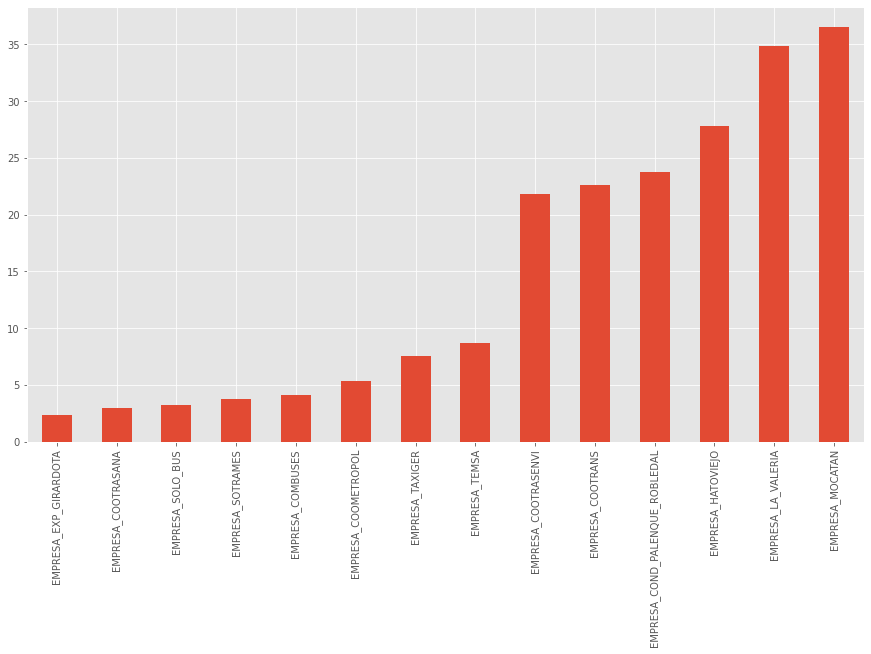

In [105]:
from matplotlib import pyplot as plt
empresas1=model_1.params[4:18]
plt.figure(figsize=(15,8))
fig1=empresas1.sort_values().plot(kind="bar")
plt.xticks(rotation= 90)
plt.savefig("coef_model1_prov_tec.jpg")

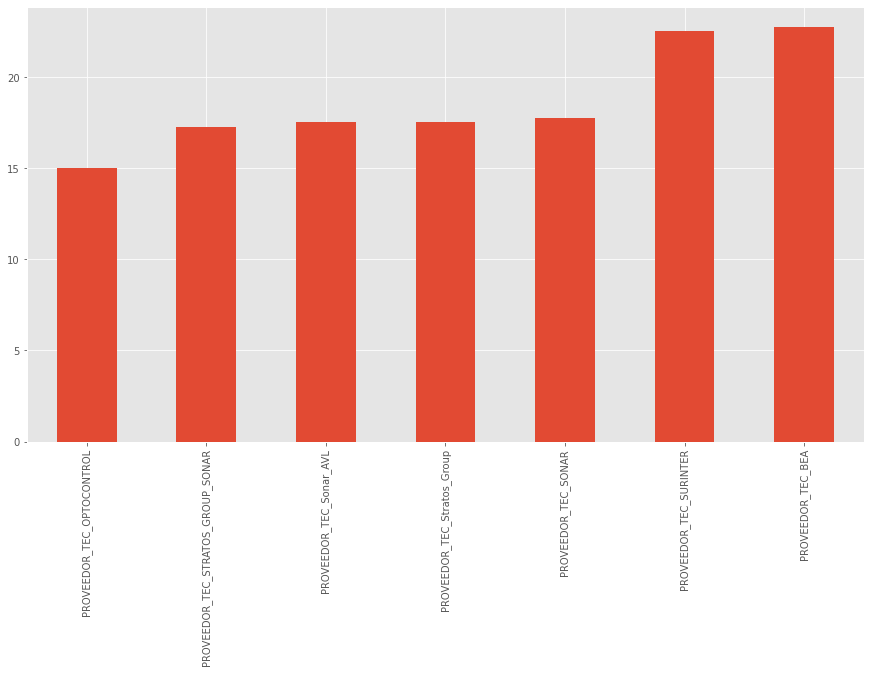

In [106]:
plt.figure(figsize=(15,8))
tec1=model_1.params[18:25]
fig1=tec1.sort_values().plot(kind="bar")
plt.xticks(rotation= 90)
plt.savefig("coef_model1_prov_tec.jpg")

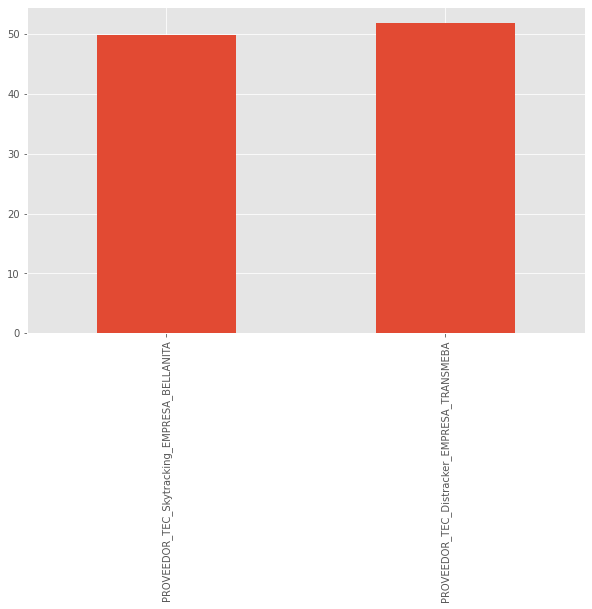

In [107]:
plt.figure(figsize=(10,6))
tec_emp1=model_1.params[25:]
fig1=tec_emp1.sort_values().plot(kind="bar")
plt.savefig("coef_model1_especial.jpg")